In [38]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
from segmentacion.globalT import thresholdingGlobal
from formas_binarias import ErosionBin
from formas_binarias import etiquetas_c

In [39]:
imagen = cv2.imread('imagenesPruebas/Kmeans.png')
img = np.array(imagen)

In [40]:
print(img.shape)
imgRecortada = img[:580,:,:]

(963, 693, 3)


In [41]:
def rgb2grayInverse(rgb):
    return np.dot(rgb[..., :3], [0.114, 0.587, 0.299]).astype(np.uint8)

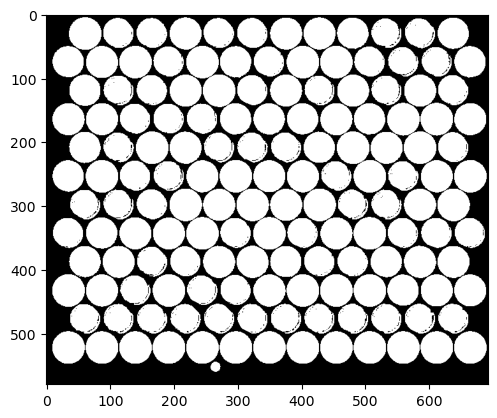

In [54]:
from segmentacion.bernsen import Bernsen
img = np.array(imgRecortada)
imggrayI= rgb2grayInverse(img)
globalX = thresholdingGlobal(imggrayI, 30)
globalXI = globalX
plt.imshow(globalXI, cmap ='gray')

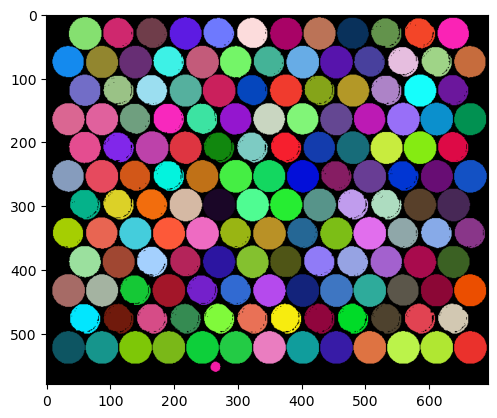

In [55]:
colors = etiquetas_c(globalXI)
plt.imshow(colors)

(-0.5, 692.5, 579.5, -0.5)

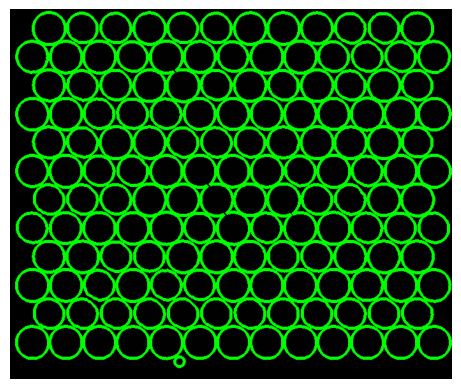

In [44]:
contours, _ = cv2.findContours(globalXI, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

contours_img_before_filtering = globalXI.copy()
contours_img_before_filtering = cv2.cvtColor(contours_img_before_filtering, cv2.COLOR_GRAY2BGR)
cv2.drawContours(contours_img_before_filtering, contours, -1, (0, 255, 0), 3)
plt.imshow(contours_img_before_filtering)
plt.axis('off')

In [45]:
filtered_contours = []
df_mean_color = pd.DataFrame()
for idx, contour in enumerate(contours):
    area = int(cv2.contourArea(contour))

    # if area is higher than 3000:
    if area > 3000:
        filtered_contours.append(contour)
        # get mean color of contour:
        masked = np.zeros_like(imgRecortada[:, :, 0])  # This mask is used to get the mean color of the specific bead (contour), for kmeans
        cv2.drawContours(masked, [contour], 0, 255, -1)

        B_mean, G_mean, R_mean, _ = cv2.mean(imgRecortada, mask=masked)
        df = pd.DataFrame({'B_mean': B_mean, 'G_mean': G_mean, 'R_mean': R_mean}, index=[idx])
        df_mean_color = pd.concat([df_mean_color, df])

df_mean_color.head()

B_mean      G_mean      R_mean
42  199.819611  174.526447   37.475549
43  199.917186  174.396358   37.494138
54   61.292250  186.043250  140.460250
65  141.727527   98.457025  190.101561
66  126.352444  140.252688  162.058569

In [46]:
from sklearn.cluster import KMeans
km = KMeans( n_clusters=6)
df_mean_color['label'] = km.fit_predict(df_mean_color)

d:\anaconda\settings\envs\primer\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\anaconda\settings\envs\primer\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [47]:
df_mean_color.head()

B_mean      G_mean      R_mean  label
42  199.819611  174.526447   37.475549      1
43  199.917186  174.396358   37.494138      1
54   61.292250  186.043250  140.460250      3
65  141.727527   98.457025  190.101561      4
66  126.352444  140.252688  162.058569      2

(-0.5, 692.5, 579.5, -0.5)

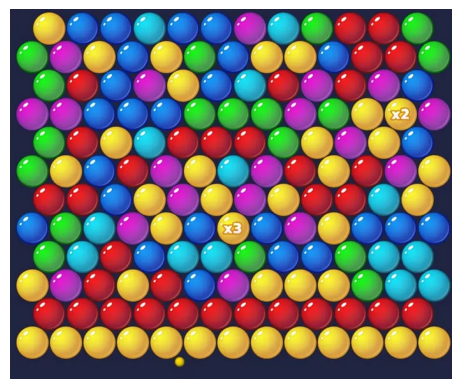

In [48]:
def draw_segmented_objects(image, contours, label_cnt_idx, bubbles_count):
    mask = np.zeros_like(image[:, :, 0])
    cv2.drawContours(mask, [contours[i] for i in label_cnt_idx], -1, (255), -1)
    masked_image = cv2.bitwise_and(image, image, mask=mask)
    masked_image = cv2.putText(masked_image, f'{bubbles_count} bubbles', (200, 1200), cv2.FONT_HERSHEY_SIMPLEX,
                        fontScale = 3, color = (255, 255, 255), thickness = 10, lineType = cv2.LINE_AA)
    return masked_image

image = imgRecortada.copy()
for label, df_grouped in df_mean_color.groupby('label'):
    bubbles_amount = len(df_grouped)
    masked_image = draw_segmented_objects(imgRecortada, contours, df_grouped.index, bubbles_amount)
    image = cv2.hconcat([img, masked_image])

cv2.imwrite('color_segmentation.png', image)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB) )
plt.axis('off')



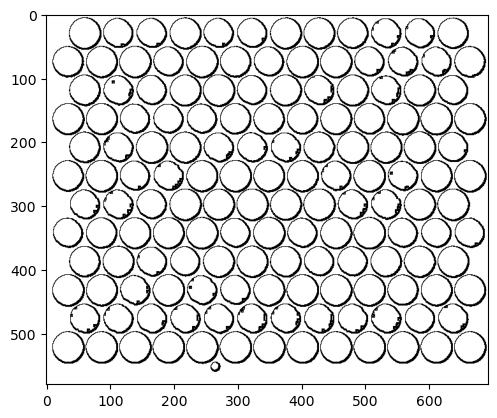

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_erosion

def detectar_bordes_binarios(imagen_binaria):
    bordes = imagen_binaria - ErosionBin(imagen_binaria, 5)
    return bordes
bordes_detectados = detectar_bordes_binarios(globalXI)
plt.imshow(bordes_detectados, cmap ='binary')


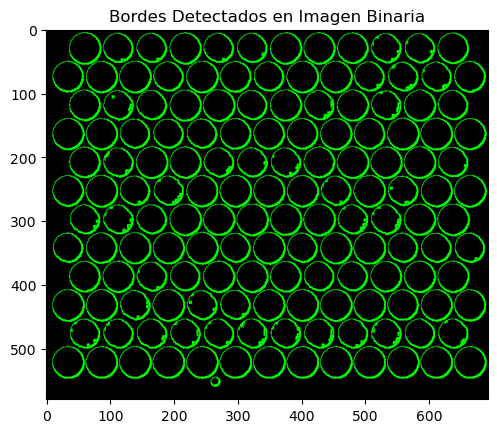

In [50]:
canalVerde = np.zeros_like(bordes_detectados)
canalRojo = np.where(bordes_detectados == 1, 255, bordes_detectados)
CanalAzul = np.zeros_like(bordes_detectados)
matriz_visualizada = np.stack((canalVerde, canalRojo, CanalAzul), axis=-1)
plt.imshow(matriz_visualizada)
plt.title('Bordes Detectados en Imagen Binaria')
plt.show()

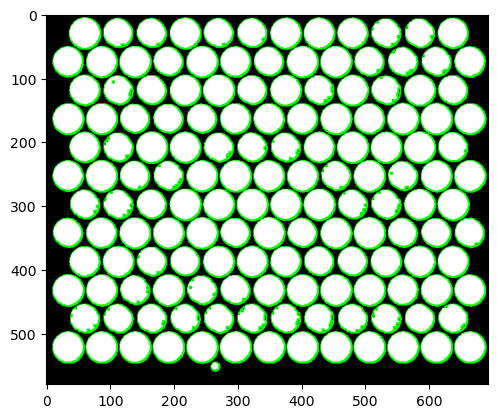

In [51]:
combination = np.zeros_like(matriz_visualizada)  # Crea una matriz de ceros del mismo tamaño que globalX

for x in range(img.shape[1]):
    for y in range(img.shape[0]):
        if globalXI[y, x] == 1:
            combination[y, x, :] =[255,255,255]
        else:
            combination[y, x, :] =[0,0,0]
        if (matriz_visualizada[y,x,1] == 255):
            combination[y, x, :] = matriz_visualizada[y,x,:]

plt.imshow(combination)
plt.show()

In [52]:
filtered_contours = []
df_mean_color = pd.DataFrame()
for idx, contour in enumerate(matriz_visualizada):
    area = int(cv2.contourArea(contour))

    # if area is higher than 3000:
    if area > 3000:
        filtered_contours.append(contour)
        # get mean color of contour:
        masked = np.zeros_like(image[:, :, 0])  # This mask is used to get the mean color of the specific bead (contour), for kmeans
        cv2.drawContours(masked, [contour], 0, 255, -1)

        B_mean, G_mean, R_mean, _ = cv2.mean(image, mask=masked)
        df = pd.DataFrame({'B_mean': B_mean, 'G_mean': G_mean, 'R_mean': R_mean}, index=[idx])
        df_mean_color = pd.concat([df_mean_color, df])

df_mean_color.head()

error: OpenCV(4.8.1) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\shapedescr.cpp:315: error: (-215:Assertion failed) npoints >= 0 && (depth == CV_32F || depth == CV_32S) in function 'cv::contourArea'


In [ ]:
import pandas as pd
import numpy as np 
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def disEuclidian(point1, point2):
    return np.sqrt(sum((x - y) ** 2 for x, y in zip(point1, point2)))

def centroidsRand(data, k):
    centroids = random.sample(data, k)
    return centroids

def AsignCentroids(data, centroids):
    clusters = [[] for _ in range(len(centroids))]
    
    for point in data:
        distances = [disEuclidian(point, centroid) for centroid in centroids]
        cluster_index = distances.index(min(distances))
        clusters[cluster_index].append(point)
    
    return clusters

def newCentroids(clusters):
    centroids = []
    for cluster in clusters:
        cluster_center = [sum(point[i] for point in cluster) / len(cluster) for i in range(len(cluster[0]))]
        centroids.append(cluster_center)
    return centroids

def covergencia(old_centroids, new_centroids, tol=1e-4):
    return all(disEuclidian(old, new) < tol for old, new in zip(old_centroids, new_centroids))

def k_means(data, k):
    centroids = centroidsRand(data, k)
    converged = False
    
    while not converged:
        clusters = AsignCentroids(data, centroids)
        new_centroids = newCentroids(clusters)
        converged = covergencia(centroids, new_centroids)
        centroids = new_centroids
    
    return centroids, clusters

def plot_clusters(centroids, clusters):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Graficar puntos y centroides
    for i, cluster in enumerate(clusters):
        x, y = zip(*cluster)
        ax1.scatter(x, y, label=f'Cluster {i + 1}')

    centroids_x, centroids_y = zip(*centroids)
    ax1.scatter(centroids_x, centroids_y, color='black', marker='x', s=100, label='Centroides')

    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_title('K-Means Clustering')
    ax1.legend()
    ax1.grid(True)

def plot_clusters_3d(centroids, clusters):
    fig = plt.figure(figsize=(10, 6))
    ax1 = fig.add_subplot(111, projection='3d')

    for i, cluster in enumerate(clusters):
        x, y, z = zip(*cluster)
        ax1.scatter(x, y, z, label=f'Cluster {i + 1}')

    centroids_x, centroids_y, centroids_z = zip(*centroids)
    ax1.scatter(centroids_x, centroids_y, centroids_z, color='black', marker='x', s=100, label='Centroides')

    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.set_title('K-Means Clustering in 3D')
    ax1.legend()

    plt.show()

def calculate_inertia(k, clusters, centroids):
    total_inertia = 0
    for i in range(k):
        cluster_points = clusters[i]
        centroid = centroids[i]
        inertia_cluster = sum(disEuclidian(centroid, point) ** 2 for point in cluster_points)
        total_inertia += inertia_cluster
    return total_inertia


In [ ]:
def kMeansCompleteIMG(IMG, k): 
    R, G, B = IMG[:, :, 0].reshape(-1, 1) , IMG[:, :, 1].reshape(-1, 1) , IMG[:, :, 2].reshape(-1, 1)
    nueva_matriz = np.column_stack((R, G, B))
    data_list = nueva_matriz.tolist()
    centroids, clusters = k_means(data_list, k)    
    
    inertia = []
    for k in range(1, len(clusters) + 1):
        total_inertia = calculate_inertia(k, clusters, centroids)
        inertia.append(total_inertia)

    plot_clusters_3d(centroids, clusters)
  
    for i, centroid in enumerate(centroids):
        print(f"Centroide {i + 1}: {centroid}")
        print(f"Puntos en el cluster {i + 1}: {clusters[i]}")
        
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(clusters) + 1), inertia, marker='o', linestyle='-', color='b')
    plt.xlabel('Número de Clusters (k)')
    plt.ylabel('Inercia')
    plt.title('Método del Codo para Determinar k')
    plt.grid(True)
    plt.show()

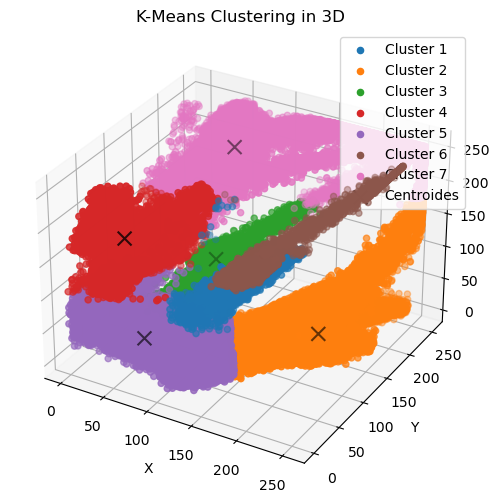

Centroide 1: [164.71179406651336, 58.1735741125007, 146.41108182379003]
Puntos en el cluster 1: [[118, 30, 94], [121, 29, 99], [122, 29, 103], [121, 30, 104], [121, 34, 102], [120, 37, 100], [118, 38, 94], [121, 31, 103], [139, 37, 117], [149, 38, 129], [157, 39, 140], [159, 36, 145], [160, 36, 149], [162, 36, 152], [159, 39, 152], [158, 42, 150], [159, 45, 146], [156, 48, 138], [151, 47, 127], [140, 40, 113], [132, 37, 103], [125, 37, 94], [110, 29, 99], [131, 36, 120], [149, 40, 140], [160, 38, 149], [167, 36, 155], [171, 32, 160], [172, 31, 166], [174, 28, 170], [172, 35, 169], [172, 38, 164], [170, 39, 158], [169, 41, 151], [166, 44, 143], [166, 49, 141], [154, 47, 130], [144, 46, 121], [131, 42, 109], [117, 37, 93], [124, 29, 113], [144, 31, 136], [167, 40, 161], [179, 39, 164], [172, 36, 156], [167, 40, 154], [160, 42, 148], [154, 43, 141], [142, 42, 129], [133, 42, 116], [119, 40, 98], [114, 27, 102], [140, 35, 132], [158, 35, 155], [172, 33, 169], [177, 37, 169], [168, 37, 163]

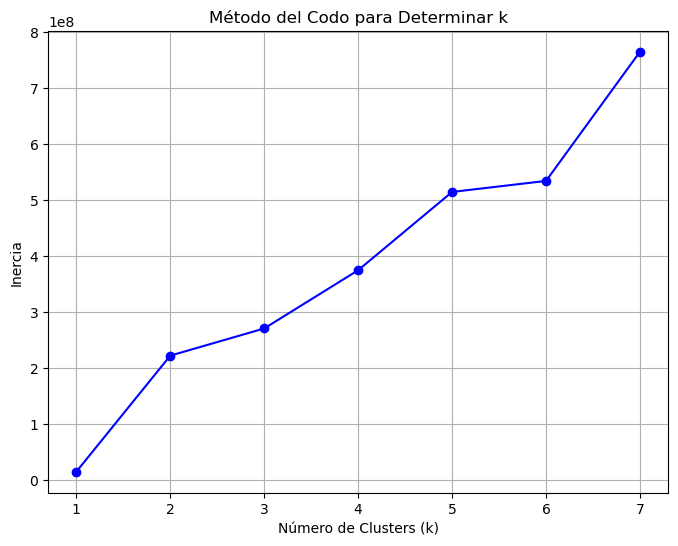

In [ ]:
kMeansCompleteIMG(imgRecortada, 7)